# Семинар 2 – Линейные модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy.stats as st
import warnings

warnings.simplefilter('ignore')
plt.style.use('seaborn')

%matplotlib inline

# 1. Постановка задачи

Разберем что такое линейная модель в машинном обучении.

![picture](https://drive.google.com/uc?export=view&id=1pNRo9-N2Udjv3AK0uTJ0qCWkk9Ko_9TA)

Где линейная модель - это:

$\hat{y} = f(x) = \theta_0*1 + \theta_1*x_1 + ... + \theta_n*x_n = \theta^T*X$

Сгенерируем исскуственные данные, на основе функции:

$f(x) = 4x+5$

In [2]:
# реализуем функцию для данных
def linear_function(x):
    return 4 * x + 5

# првоерим корректность по 2 точкам
x_true = np.array([-2, 2])
y_true = linear_function(x_true)

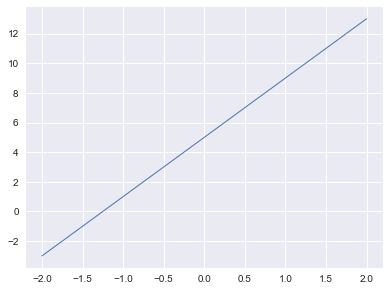

In [3]:
plt.figure(figsize=(6.4 * 1, 4.8 * 1))

plt.plot(x_true, y_true, linewidth=1)
plt.show()

In [4]:
# сгенерируем выборку

n = 100  # количество данных
x = np.random.rand(n, 1) * 4 - 2  # исходные данные
e = np.random.rand(n, 1) * 4 - 2  # шум
y = linear_function(x) + e  # распределение

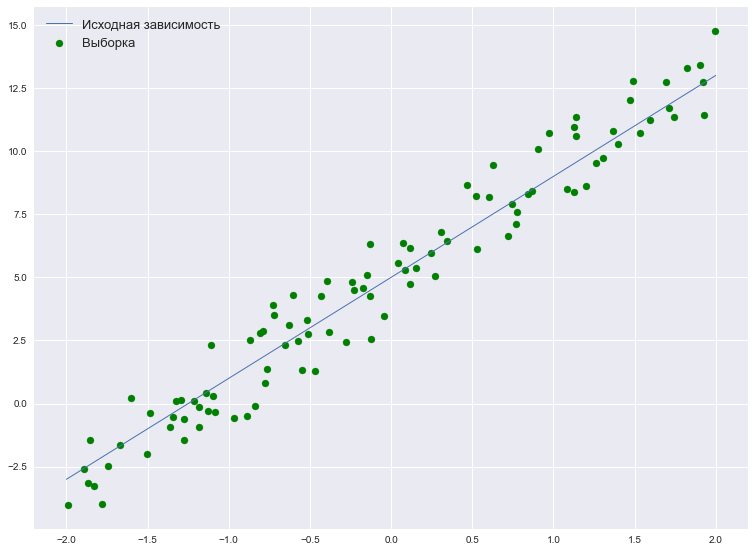

In [5]:
# изобразим данные на графике
plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.scatter(x, y, color='g', label='Выборка')
plt.plot(x_true, y_true, linewidth=1, label='Исходная зависимость') 

plt.legend(loc='upper left', fontsize=13)
plt.show()

# 2. Метрики

Нашей задачей сейчас будет построить модель, восстанавливающую исходное распределение. Для того, чтобы оценить насколько модель хорошо работает введем метрики для оценки.

1. __Mean Absoulte Error (MAE):__

$MAE = \frac1N \sum_{i = 1}^N|f(x_i) - y_i| = \frac1N \sum_{i = 1}^N|\hat y_i - y_i| = \frac1N || \hat Y - Y||_1$

2.  __Mean Sqared Error (MSE):__

$MSE = \frac1N \sum_{i = 1}^N(f(x_i) - y_i)^2 = \frac1N \sum_{i = 1}^N(\hat y_i - y_i)^2 = \frac1N ||\hat Y - Y||_2$

# 3. Аналитическое решение

Если мы хотим найти минимум какой-то функции (в нашем случае метрики), то можем сделать это через поиск экстермума, то есть решить задачу: $MSE \to min $.

Перепишем MSE в следующем виде:

$MSE = \frac1N \sum_{i = 1}^N(\hat y_i - y_i)^2 = \frac1N \sum_{i = 1}^N(\theta_i * x_i - y_i)^2 = \frac1N ||X \theta - Y||_2 = \frac1N (X\theta - Y)^T*(X\theta - Y)$

Видим, что переменная, по которой требуется найти минимум - это $\theta$:

$\frac{d}{d\theta}[\frac1N (X\theta - Y)^T*(X\theta - Y)] =  \frac1N \frac{d}{d\theta}[Y^TY - 2Y^TX\theta+\theta^TX^TX\theta]$

Таким образом:

$\hat \theta = \bigl(X^T \cdot X  \bigr)^{-1} \cdot X^T \cdot y $

In [6]:
# инициализация матрицы Х (добавляем bias)

x_matrix = np.hstack([np.ones((n, 1)), x])

In [7]:
%%time

# найдем аналитическое решение
theta_matrix = np.dot(np.linalg.inv(np.dot(x_matrix.T, x_matrix)), x_matrix.T) @ y

Wall time: 0 ns


Обратите внимание на время работы

In [8]:
print("Свободный член: {[0][0]:.7}".format(theta_matrix.T))
print("Коэфициент: {[0][1]:.7}".format(theta_matrix.T))

Свободный член: 5.048007
Коэфициент: 4.18662


## 3.1 Аналитическое решение в sklearn

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [10]:
# зададим модель
lr = LinearRegression()

In [11]:
%%time

# аналитическое решение
lr.fit(x,y);

Wall time: 990 µs


LinearRegression()

In [12]:
print("Свободный член: {:.7}".format(lr.intercept_[0]))
print("Коэфициент: {:.7}".format(lr.coef_[0][0]))

Свободный член: 5.048007
Коэфициент: 4.18662


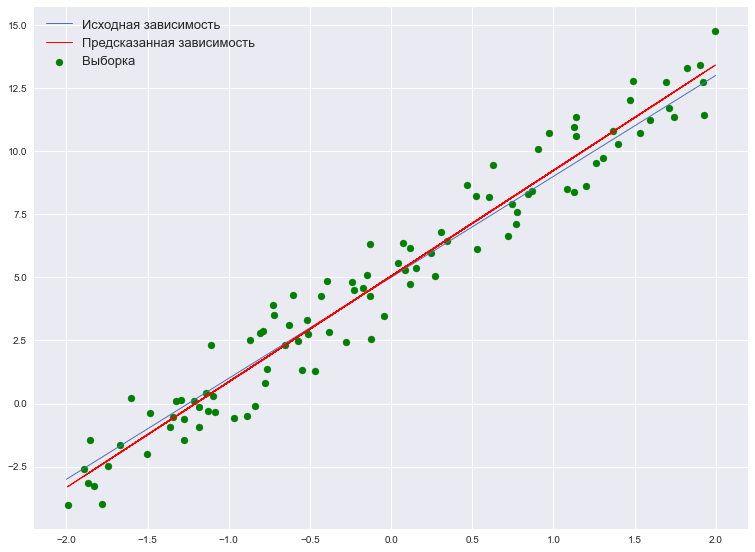

In [13]:
# изобразим результаты аналитического решения
plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.scatter(x, y, color='g', label='Выборка')
plt.plot(x_true, y_true, linewidth=1, label='Исходная зависимость')
plt.plot(x, lr.predict(x), linewidth=1, color='r', label='Предсказанная зависимость')

plt.legend(loc='upper left', fontsize=13)
plt.show()

# 4. Численное решение
## 4.1. Градиентный спуск

Вспомним примитивную реализацию одного из методов оптимизации - градиентный спуск:

$\theta^{(t+1)} = \theta^{(t)} - lr\cdot \nabla MSE(\theta^{(t)}),$


где $lr$ - длина шага градиентного спуска (learning rate), $t$ - шаг обучения. 

В нашем случае:

$\nabla MSE(\theta)= \frac{2}{N} X^T \cdot \bigl(X \cdot \theta - Y \bigr) $

In [14]:
%%time
lr = 0.1  # шаг обучения
n_iterations = 150  # количество итераций

theta = np.random.randn(2,1)  # начальная инициализация
iter_solutions = [theta]

for iteration in range(n_iterations):       
    gradients = 2 / n * x_matrix.T @ (x_matrix @ theta - y) 
    theta = theta - lr * gradients
    
    iter_solutions.append(theta)

Wall time: 1.02 ms


In [15]:
print("Свободный член: {:.7}".format(theta[0, 0]))
print("Коэфициент: {:.7}".format(theta[1, 0]))

Свободный член: 5.048007
Коэфициент: 4.18662


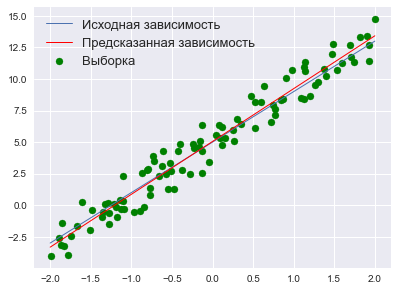

In [16]:
# изобразим результаты численного решения

plt.figure(figsize=(6.4 * 1, 4.8 * 1))

plt.scatter(x, y, color='g', label='Выборка')
plt.plot(x_true, y_true, linewidth=1, label='Исходная зависимость')
plt.plot(x_true, x_true * theta[1] + theta[0], linewidth=1, color='r', label='Предсказанная зависимость')

plt.legend(loc='upper left', fontsize=13)
plt.show()

In [17]:
def animate_solutions(iter_solutions):

    fig, ax = plt.subplots(figsize=(6.4 * 1, 4.8 * 1))

    def update(idx):
        _theta = iter_solutions[idx]
        
        ax.clear()       
        
        ax.scatter(x, y, color='g', label='Выборка')
        ax.plot(x_true, y_true, linewidth=1, label='Исходная зависимость')
        ax.plot(x_true, x_true * _theta[1] + _theta[0], linewidth=1, color='r', label='Предсказанная зависимость')
        
        ax.legend(loc='upper left', fontsize=13)

    fps = 3
    ani = animation.FuncAnimation(fig, update, len(iter_solutions), interval=100 / fps)
    
    return ani

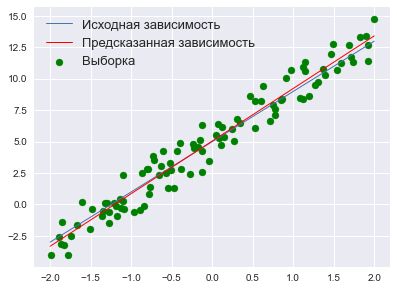

In [18]:
ani = animate_solutions(iter_solutions)
HTML(ani.to_html5_video())

### Слишком маленький шаг обучения (learning rate)

In [19]:
lr = 0.01  # шаг обучения
n_iterations = 150  # количество итераций

theta = np.random.randn(2,1)  # начальная инициализация
iter_solutions = [theta]

for iteration in range(n_iterations):       
    gradients = 2 / n * x_matrix.T @ (x_matrix @ theta - y) 
    theta = theta - lr * gradients
    
    iter_solutions.append(theta)
    
    
print("Свободный член: {:.7}".format(theta[0, 0]))
print("Коэфициент: {:.7}".format(theta[1, 0]))

Свободный член: 4.77811
Коэфициент: 3.985659


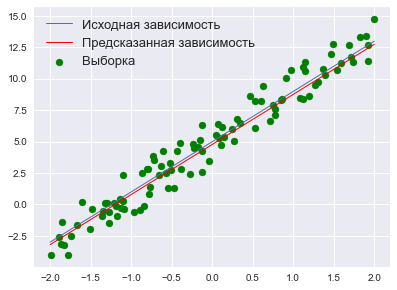

In [20]:
ani = animate_solutions(iter_solutions)
HTML(ani.to_html5_video())

### Слишком большой шаг обучения (learning rate)

In [21]:
lr = 1.1  # шаг обучения
n_iterations = 150  # количество итераций

theta = np.random.randn(2,1)  # начальная инициализация
iter_solutions = [theta]

for iteration in range(n_iterations):       
    gradients = 2 / n * x_matrix.T @ (x_matrix @ theta - y) 
    theta = theta - lr * gradients
    
    iter_solutions.append(theta)

    
print("Свободный член: {:.7}".format(theta[0, 0]))
print("Коэфициент: {:.7}".format(theta[1, 0]))

Свободный член: 7.751062e+36
Коэфициент: -2.643919e+37


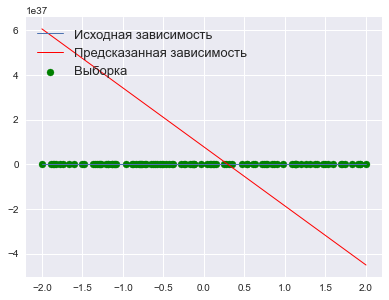

In [22]:
ani = animate_solutions(iter_solutions)
HTML(ani.to_html5_video())

### Уменьшение шага на каждой итерации

In [23]:
lr = 1  # шаг обучения
n_iterations = 150  # количество итераций

theta = np.random.randn(2,1)  # начальная инициализация
iter_solutions = [theta]

for iteration in range(n_iterations):       
    gradients = 2 / n * x_matrix.T @ (x_matrix @ theta - y) 
    theta = theta - (lr - iteration / n_iterations) * gradients
    
    iter_solutions.append(theta)
    
    
print("Свободный член: {:.7}".format(theta[0, 0]))
print("Коэфициент: {:.7}".format(theta[1, 0]))

Свободный член: 5.048007
Коэфициент: 4.18662


Learning rate - гипперпараметр, и можно воспользоваться GridSearchCV, однако чтобы не учить каждый раз такое кол-во итераций, мы можем измерять норму градиента, и прекращать спуск, когда он затухает.

In [24]:
gradients

array([[ 3.36536354e-16],
       [-1.10675358e-15]])

In [25]:
lr = 1  # шаг обучения
n_iterations = 1500  # количество итераций
tol = 1e-4

theta = np.random.randn(2,1)  # начальная инициализация
iter_solutions = [theta]

for iteration in range(n_iterations):
    gradients = 2 / n * x_matrix.T @ (x_matrix @ theta - y) 
    
    if np.max(np.abs(gradients)) < tol:
        break
    
    theta = theta - (lr - iteration / n_iterations) * gradients
    iter_solutions.append(theta)

print('Градиент затух на {} итерации '.format(iteration))
print("Свободный член: {:.7}".format(theta[0, 0]))
print("Коэфициент: {:.7}".format(theta[1, 0]))

Градиент затух на 587 итерации 
Свободный член: 5.047997
Коэфициент: 4.186655


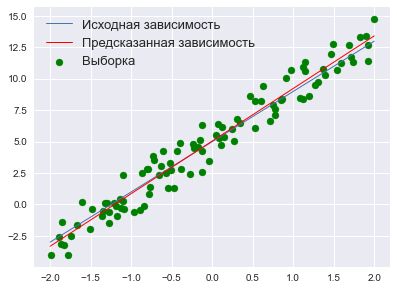

In [26]:
ani = animate_solutions(iter_solutions)
HTML(ani.to_html5_video())

__Реализация в Scikit-Learn отсутствует__
  
  

## 4.1. Cтохастический градиентный спуск  

У среднего случайных подвыборок то же что и у всех данных

In [27]:
!pip install tqdm

In [28]:
from tqdm import tqdm

In [29]:
lr = 1e-1  # шаг обучения
n_epochs = 100

def learning_schedule(t):
    return t0 / (t + t1)

t0, t1 = 5, 100  # learning schedule hyperparameters
tol = 1e-5

theta = np.random.randn(2,1)  # начальная инициализация
iter_solutions = [theta]

for epoch in tqdm(range(n_epochs)):
    for i in range(n):
        random_index = np.random.randint(n)
        xi = x_matrix[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        
        gradients = 2 * xi.T @ (xi @ theta - yi)
        if np.max(np.abs(gradients)) < tol:
            break
        lr = learning_schedule(epoch * n + i)
        theta = theta - lr * gradients
        iter_solutions.append(theta)

        
print('Градиент затух на {} итерации '.format(iteration))
print("Свободный член: {:.7}".format(theta[0, 0]))
print("Коэфициент: {:.7}".format(theta[1, 0]))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 711.12it/s]

Градиент затух на 587 итерации 
Свободный член: 5.070728
Коэфициент: 4.211567


## 4.2. Пакетный градиентный спуск  

In [30]:
lr = 1e-1  # шаг обучения
n_epochs = 100

def learning_schedule(t):
    return t0 / (t + t1)

t0, t1 = 5, 100  # learning schedule hyperparameters
bs = 10  # размер пакета

theta = np.random.randn(2,1)  # начальная инициализация
iter_solutions = [theta]

for epoch in range(n_epochs):
    for i in range(n):
        random_index = np.random.randint(n - bs)
        xi = x_matrix[random_index: random_index + bs]
        yi = y[random_index:random_index + bs]
        
        gradients = 2 / 10 * xi.T @ (xi @ theta - yi)
        if np.max(np.abs(gradients)) < tol:
            break
        lr = learning_schedule(epoch * n + i)
        theta = theta - lr * gradients
        iter_solutions.append(theta)


print('Градиент затух на {} итерации '.format(iteration))
print("Свободный член: {:.7}".format(theta[0, 0]))
print("Коэфициент: {:.7}".format(theta[1, 0]))

Градиент затух на 587 итерации 
Свободный член: 5.012072
Коэфициент: 4.204245


In [31]:
from sklearn.linear_model import SGDRegressor

In [32]:
#The stopping criterion. If it is not None, the iterations will stop when (loss > previous_loss - tol).
sgd = SGDRegressor(tol=1e-4)
sgd.fit(x,y)

print("Свободный член: {:.7}".format(sgd.intercept_[0]))
print("Коэфициент: {:.7}".format(sgd.coef_[0]))

Свободный член: 5.034683
Коэфициент: 4.183533


# 5. Функции потерь в регрессии

Рассмотрим аналитическое решение задачи регрессии на следующих наборах данных.

In [33]:
# подготовка данных

with open('data_preprocessed.json') as file:
    X = pd.read_json(file)
    
X_subset = X[[7, 15]].values
X_subset_modified = np.vstack((X_subset, [[1, 90], [2, 50]]))  # add two outliers

In [34]:
# аналитическое решение задачи
def scatter_points_and_plot_line_MSE(X_subset):
    plt.scatter(X_subset[:, 0], X_subset[:, 1], c='g', label='Выборка')
    lr = LinearRegression()
    lr.fit(X_subset[:, 0][:, None], X_subset[:, 1])
    grid = np.linspace(0, 2, 100)
    line = lr.predict(grid[:, None])
    plt.plot(grid, line, c='r', label='Предсказанная зависимость')
    plt.legend(loc='upper left', fontsize=13)

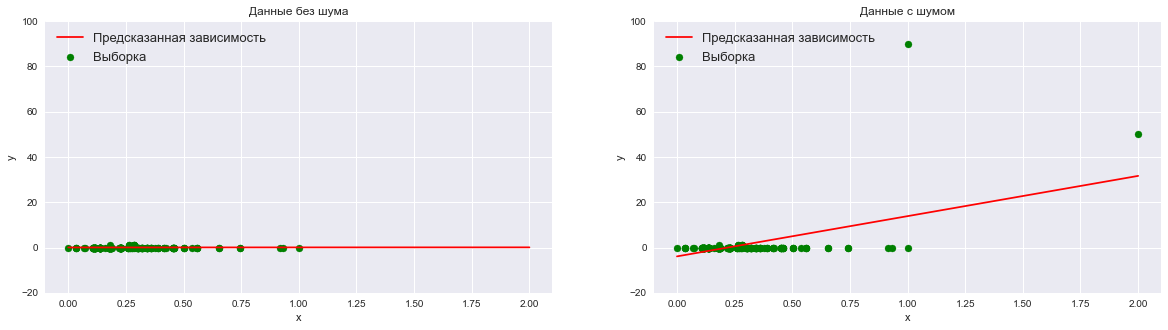

In [35]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
scatter_points_and_plot_line_MSE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.title('Данные без шума')

plt.subplot(1, 2, 2)
scatter_points_and_plot_line_MSE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.title('Данные с шумом')
plt.show()

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE часто используют Mean Absoulte Error:
$$L(y_i, a(x_i)) = |y_i - a(x_i)|$$

Теперь обучим регрессию, оптимизируя MAE. В sklearn такая регрессия не реализована, но можно использовать модуль statsmodels

In [36]:
!pip install statsmodels==0.11.1

In [37]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [38]:
mod = smf.quantreg('f15 ~ f7', pd.DataFrame(data=X_subset_modified, columns=["f7", "f15"])) # задаем зависимость и передаем данные
res = mod.fit(q=0.5)

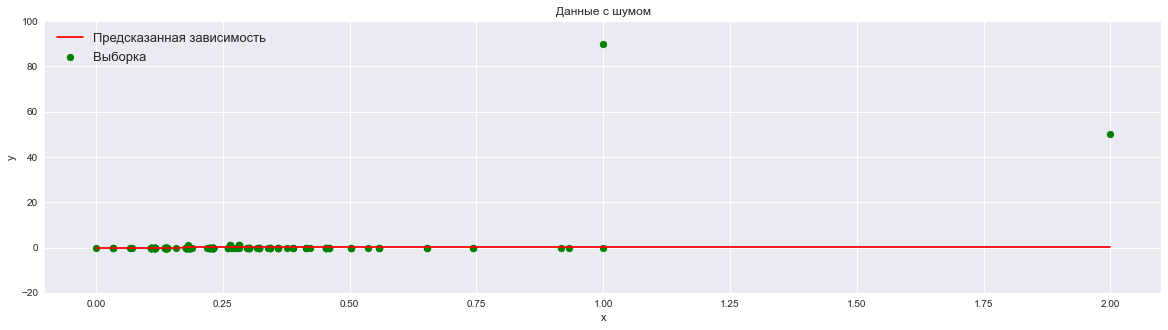

In [39]:
plt.figure(figsize=(20, 5))
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.title('Данные с шумом')

plt.scatter(X_subset_modified[:, 0], X_subset_modified[:, 1],  c='g', label='Выборка')   # визуализируем точки
grid = np.linspace(0, 2, 100)
plt.plot(grid, grid * res.params["f7"] + res.params["Intercept"], c='r', label='Предсказанная зависимость')   # визуализируем прямую

plt.legend(loc='upper left', fontsize=13)
plt.show()

Прямая не изменила направление из-за выбросов.

Попробуем добавить больше шумовых объектов:

In [40]:
X_subset_modified_twice = np.vstack((
    X_subset_modified, 
    np.random.randint(5, size=30).reshape(-1, 2) * [1, 30],
))

In [41]:
mod = smf.quantreg('f15 ~ f7', pd.DataFrame(data=X_subset_modified_twice, columns=["f7", "f15"])) # задаеем зависимость и передаем данные
res = mod.fit(q=0.5)

c:\users\l-132\anaconda3\envs\general\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


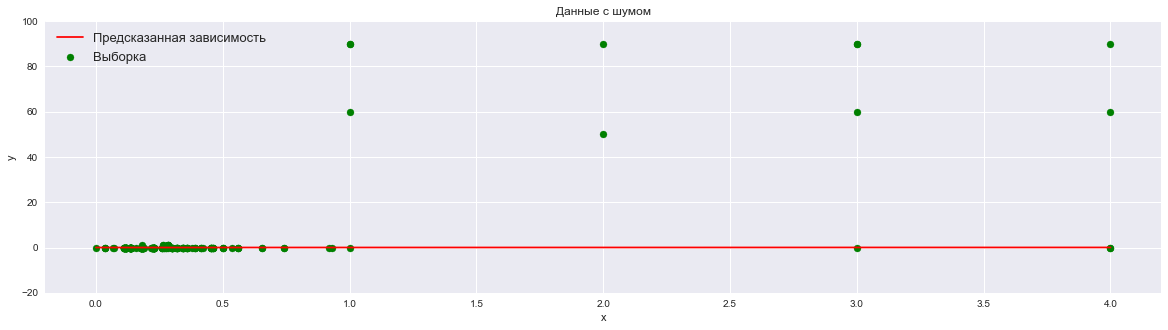

In [42]:
plt.figure(figsize=(20, 5))
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.title('Данные с шумом')

plt.scatter(X_subset_modified_twice[:, 0], X_subset_modified_twice[:, 1],  c='g', label='Выборка')   # визуализируем точки
grid = np.linspace(0, 4, 200)
plt.plot(grid, grid * res.params["f7"] + res.params["Intercept"], c='r', label='Предсказанная зависимость')   # визуализируем прямую

plt.legend(loc='upper left', fontsize=13)
plt.show()

Прямая изменила наклон, когда мы добавили 30 (почти 15%) шумовых точек.

# 6. Мультиколлинеарность и регуляризация

In [43]:
!pip install seaborn

In [44]:
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Для оценка качества работы наших алгоритмов будем использовать коэфициент детерминации:

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2}$$


## Аналитическое решение задачи

In [45]:
def my_linear_regression(X_train, Y_train):
    return np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [46]:
def predict(X, w):
    return np.dot(X, w)

## Загрузим датасет

https://habrahabr.ru/post/206306/

In [47]:
data = pd.read_csv('energy_efficiency.csv')

Для примера решения задачи прогнозирования, я взял набор данных Energy efficiency из крупнейшего репозитория UCI.   

В нем $X_1 ... X_8$ — характеристики помещения на основании которых будет проводиться анализ, а $y_1,y_2$ — значения нагрузки, которые надо спрогнозировать.
- $X_1$	Относительная компактность
- $X_2$	Площадь
- $X_3$	Площадь стен
- $X_4$	Площадь потолка	
- $X_5$	Общая высота	
- $X_6$	Ориентация
- $X_7$	Площадь остекления	
- $X_8$	Распределенная площадь остекления	
- $y_1$	Нагрузка при обогреве
- $y_2$	Нагрузка при охлаждении

In [48]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


## Посмотрим на скоррелированность данных

In [49]:
data.corr()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
X1,1.000000e+00,-9.919015e-01,-2.037817e-01,-8.688234e-01,8.277473e-01,4.678592e-17,-2.960552e-15,-7.107006e-16,0.622272,0.634339
X2,-9.919015e-01,1.000000e+00,1.955016e-01,8.807195e-01,-8.581477e-01,-3.459372e-17,3.636925e-15,2.438409e-15,-0.658120,-0.672999
X3,-2.037817e-01,1.955016e-01,1.000000e+00,-2.923165e-01,2.809757e-01,-2.429499e-17,-8.567455e-17,2.067384e-16,0.455671,0.427117
X4,-8.688234e-01,8.807195e-01,-2.923165e-01,1.000000e+00,-9.725122e-01,-5.830058e-17,-1.759011e-15,-1.078071e-15,-0.861828,-0.862547
X5,8.277473e-01,-8.581477e-01,2.809757e-01,-9.725122e-01,1.000000e+00,4.492205e-17,1.489134e-17,-2.920613e-17,0.889430,0.895785
X6,4.678592e-17,-3.459372e-17,-2.429499e-17,-5.830058e-17,4.492205e-17,1.000000e+00,-9.406007e-16,-2.549352e-16,-0.002587,0.014290
X7,-2.960552e-15,3.636925e-15,-8.567455e-17,-1.759011e-15,1.489134e-17,-9.406007e-16,1.000000e+00,2.129642e-01,0.269842,0.207505
X8,-7.107006e-16,2.438409e-15,2.067384e-16,-1.078071e-15,-2.920613e-17,-2.549352e-16,2.129642e-01,1.000000e+00,0.087368,0.050525
Y1,6.222719e-01,-6.581199e-01,4.556714e-01,-8.618281e-01,8.894305e-01,-2.586763e-03,2.698417e-01,8.736846e-02,1.000000,0.975862
Y2,6.343391e-01,-6.729989e-01,4.271170e-01,-8.625466e-01,8.957852e-01,1.428960e-02,2.075050e-01,5.052512e-02,0.975862,1.000000


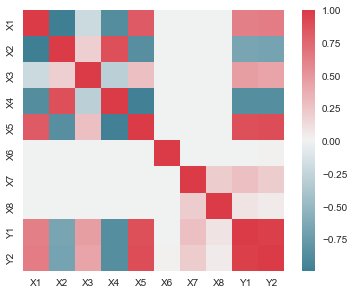

In [50]:
f, ax = plt.subplots(figsize=(6.4, 4.8))

corr = data.corr()
sns.heatmap(corr, square=True, ax=ax, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

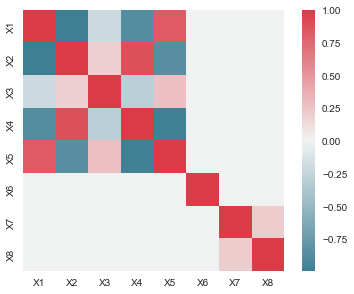

In [51]:
f, ax = plt.subplots(figsize=(6.4, 4.8))

corr = data.drop(['Y1','Y2'], axis=1).corr()
sns.heatmap(corr, square=True, ax=ax, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

Видим, что x1 скоррелирован с x2, а x4 с x5. Из-за этого матрица $X^{T}*X$ необратима.

## Посмотрим как на таких данных отработает наша линейная регрессия

Разобьем выборку на train и test

In [52]:
X = data.drop(['Y1','Y2'], axis=1)
y = data['Y1']

In [53]:
X.shape, y.shape

((768, 8), (768,))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучим регрессию и посмотрим на качество

In [55]:
w = my_linear_regression(X_train, y_train)

In [56]:
y_train_pred = predict(X_train, w)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train R2: ", r2_score(y_train, y_train_pred))

Train MSE:  1.546464753412917e+28
Train R2:  -1.5323075753218484e+26


In [57]:
y_test_pred = predict(X_test, w)
print("Test MSE: ", mean_squared_error(y_test, y_test_pred))
print("Test R2: ", r2_score(y_test, y_test_pred))

Test MSE:  1.6819385825774222e+28
Test R2:  -1.6136426224492343e+26


Как-то не очень

## Попробуем убрать скоррелированные признаки

In [58]:
X = data.drop(['Y1','Y2','X1','X2','X3'],axis=1)
y = data['Y1']

In [59]:
X.shape, y.shape

((768, 5), (768,))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучим регрессию и посмотрим на качество

In [61]:
w = my_linear_regression(X_train, y_train)

In [62]:
y_train_pred = predict(X_train, w)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train R2: ", r2_score(y_train, y_train_pred))

Train MSE:  13.671095265604665
Train R2:  0.8645405736393182


In [63]:
y_test_pred = predict(X_test, w)
print("Test MSE: ", mean_squared_error(y_test, y_test_pred))
print("Test R2: ", r2_score(y_test, y_test_pred))

Test MSE:  15.011797571120464
Test R2:  0.8559776400204862


Получили алгоритм с хорошим качеством.

## Реализуем линейную регрессию с L2 регуляризацией

In [64]:
def my_linear_regression(X_train, Y_train, l2=0):
    return np.linalg.inv(X_train.T.dot(X_train) + l2 * np.eye(X_train.shape[1])).dot(X_train.T).dot(y_train)

Обучим регрессию с регуляризацией и посмотрим на качество

In [65]:
X = data.drop(['Y1','Y2'], axis=1)
y = data['Y1']

In [66]:
X.shape, y.shape

((768, 8), (768,))

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
w = my_linear_regression(X_train, y_train, l2=0.001)

In [69]:
y_train_pred = predict(X_train, w)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train R2: ", r2_score(y_train, y_train_pred))

Train MSE:  8.566900417775278
Train R2:  0.915115256405201


In [70]:
y_test_pred = predict(X_test, w)
print("Test MSE: ", mean_squared_error(y_test, y_test_pred))
print("Test R2: ", r2_score(y_test, y_test_pred))

Test MSE:  9.463828410652237
Test R2:  0.9092045509083178


Этого же эффекта (отсутствие переобучения) добились добавив регуляризацию.